In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import cv2

In [2]:
def show_image(image, title="Image", cmap='grey'):
    plt.imshow(image,cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [12]:
ch = np.load('./Post/plan.npy')

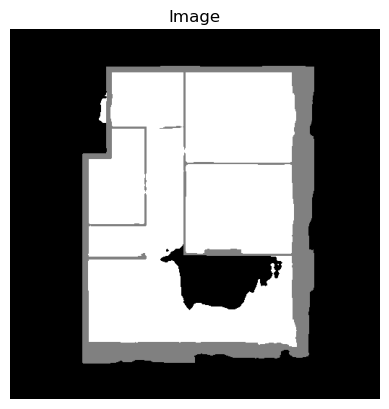

In [4]:
show_image(ch[1])

In [5]:
def inner(zo):
    zo = zo.copy()
    contours, hierarchy = cv2.findContours(zo[0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    inner_spot_mask = np.zeros_like(zo[0])
    cv2.fillPoly(inner_spot_mask, contours[2:], 1)
    mask = inner_spot_mask.astype(np.bool_)
    zo[0][mask] = 0
    zo[2][mask] = 1
    return zo.astype(np.uint8)

def crop(zo, s=20):
    zo = zo.copy()
    zo[1] = binary_dilation(zo[1], structure=np.ones((s, s))).astype(int)
    zo[1] = 1 - binary_dilation(1 - zo[1], structure=np.ones((s, s))).astype(int)
    zo[2] = binary_dilation(1-zo[2], structure=np.ones((s, s))).astype(int)
    zo[2] = binary_dilation(1-zo[2], structure=np.ones((s, s))).astype(int)
    zo[0][zo[1]+zo[2]==0] = 1
    zo[0][zo[1]+zo[2]==1] = 0
    return zo.astype(np.uint8)

def crop2(zo, s=20):
    zo = zo.copy()
    zo[1] = binary_dilation(zo[1], structure=np.ones((s, s))).astype(int)
    zo[1] = 1 - binary_dilation(1 - zo[1], structure=np.ones((s, s))).astype(int)
    zo[2] = binary_dilation(zo[2], structure=np.ones((s, s))).astype(int)
    zo[2] = 1-binary_dilation(1-zo[2], structure=np.ones((s, s))).astype(int)
    zo[0][zo[1]+zo[2]==0] = 1
    zo[0][zo[1]+zo[2]==1] = 0
    return zo.astype(np.uint8)

def filt(ic, t=30):
    ic = ic.copy()
    contours, _ = cv2.findContours(ic[2], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if not (w>t or h>t) :
            cv2.fillPoly(ic[2], [c], 0)
    contours, _ = cv2.findContours(ic[1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if not (w>t or h>t):
            cv2.fillPoly(ic[1], [c], 0)
    return ic.astype(np.uint8)

def getic(wall, icons, s=20):
    f_w = binary_dilation(icons, structure=np.ones((s, s))).astype(int)
    w_w = wall - f_w
    w_w[w_w==-1] = 0
    mask1 = np.logical_and(f_w.astype(np.bool_), wall.astype(np.bool_))
    f_wa = binary_dilation(w_w, structure=np.ones((s, s))).astype(int)
    mask2 = np.logical_or(wall.astype(np.bool_), mask1)
    f_wa[mask2==False] = 0
    win = mask1.astype(int) - f_wa
    win[win==-1]=0
    return f_wa.astype(np.uint8), win.astype(np.uint8)

def block(cons, bot, top):
    faces = []
    for con in cons:
        cp = list(con)
        cp += [cp[0]]
        for i in range(len(cp)-1):
            p1 = cp[i][0]
            p2 = cp[i+1][0]
            q1 = (p1[0], p1[1], bot)
            q2 = (p2[0], p2[1], bot)
            q3 = (p2[0], p2[1], top)
            q4 = (p1[0], p1[1], top)
            faces += [[q1, q2, q3, q4]]
    return faces

def bound(cons, h):
    faces = []
    for con in cons:
        sur = []
        for p in con:
            sur += [(p[0][0], p[0][1], h)]
        faces += [sur]
    return faces

In [13]:
zo = np.stack([ch[1]==0, ch[1]==1, ch[1]==2])
ic = np.stack([ch[2]==0, ch[2]==1, ch[2]==2])

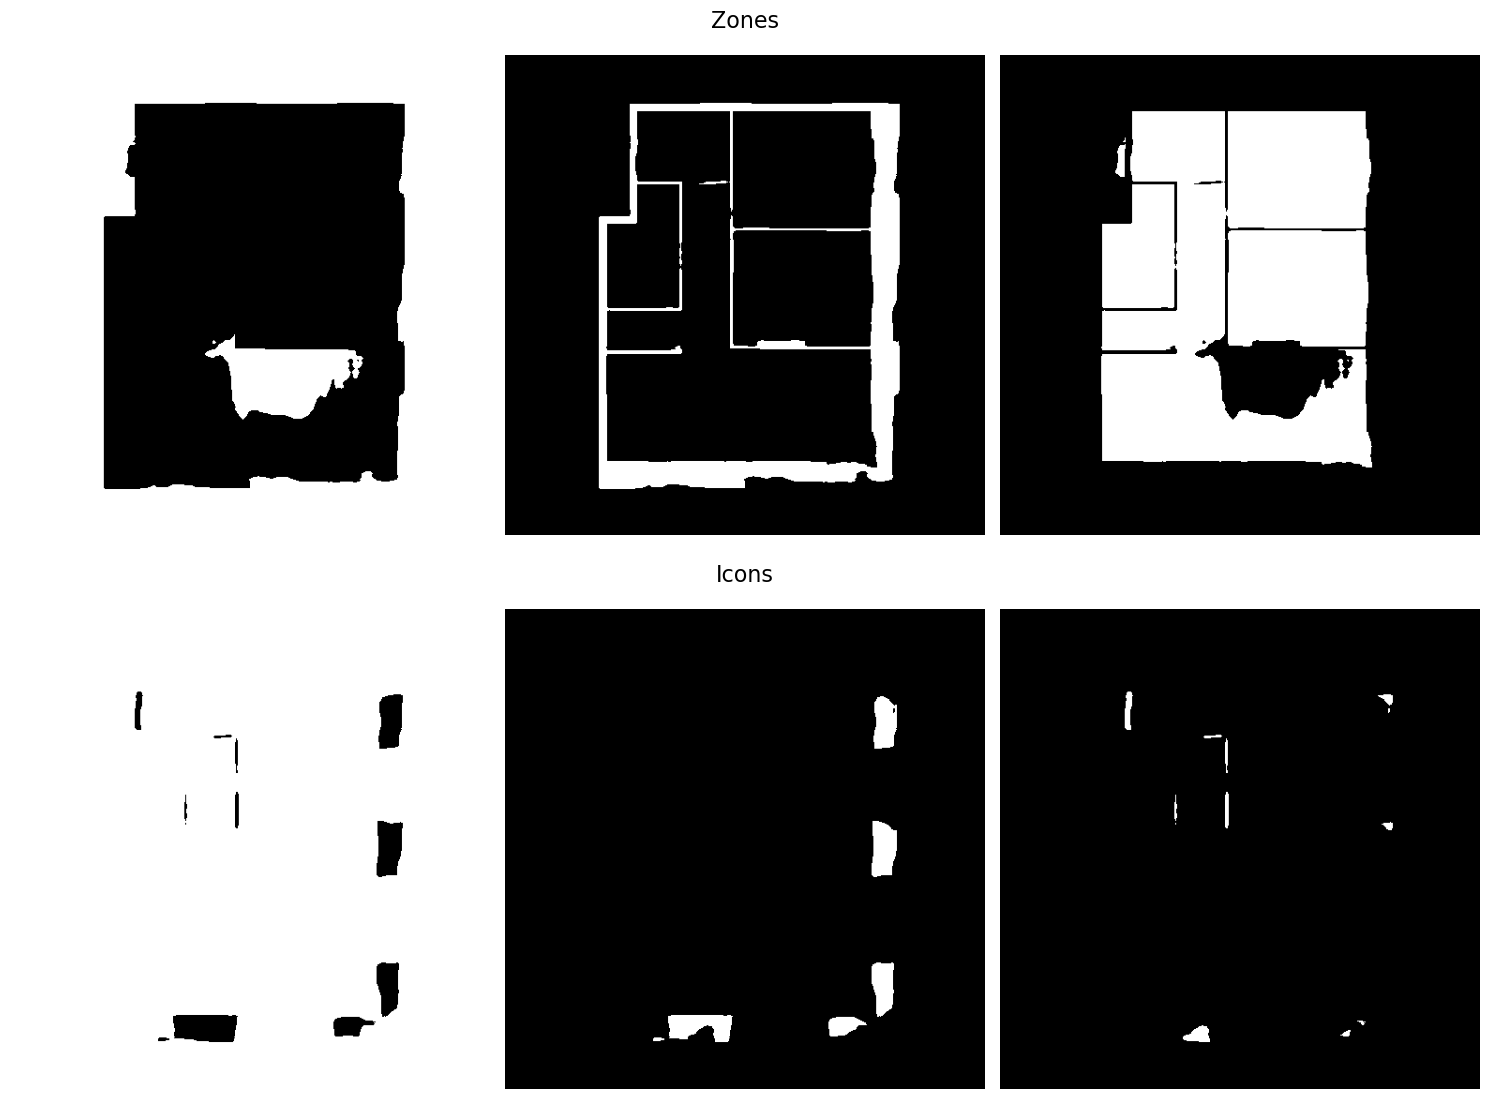

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 12))

for j in range(3):
    img = zo[j]
    axes[0, j].imshow(img,cmap='grey')
    axes[0, j].axis('off')
axes[0, 1].set_title('Zones', fontsize=16, pad=20)

for j in range(3):
    img = ic[j]
    axes[1, j].imshow(img,cmap='grey')
    axes[1, j].axis('off')
axes[1, 1].set_title('Icons', fontsize=16, pad=20)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

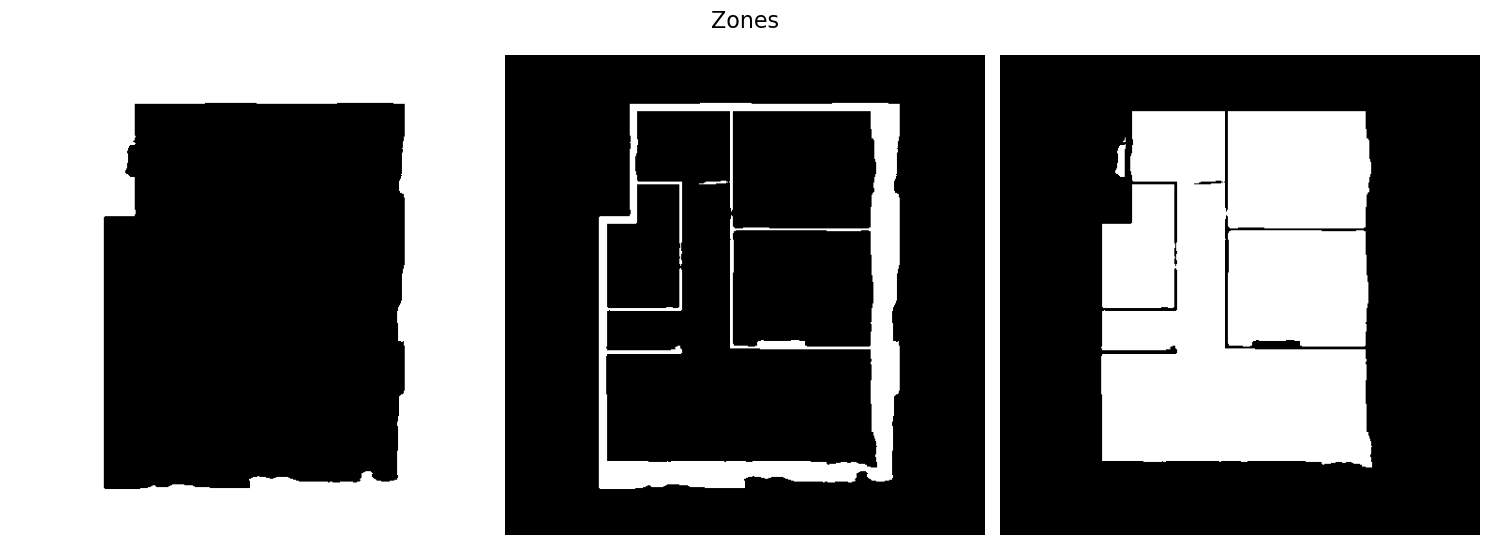

In [8]:
zo2 = inner(zo.astype(np.uint8))

fig, axes = plt.subplots(1, 3, figsize=(15, 12))

for j in range(3):
    img = zo2[j]
    axes[j].imshow(img,cmap='grey')
    axes[j].axis('off')
axes[1].set_title('Zones', fontsize=16, pad=20)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

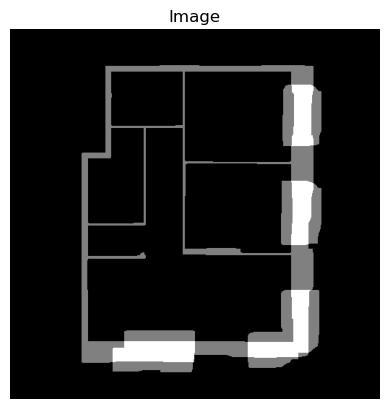

In [43]:
wind = filt(crop2(ic))[1]
door = filt(crop2(ic))[2]
wall = crop(zo2,s=30)[1]
zone = crop(zo2,s=30)[2]

waw = wall.copy()
waw[np.logical_and(wall, wind) == True] = 0
show_image(wall + binary_dilation(wind, structure=np.ones((30, 30))).astype(int))

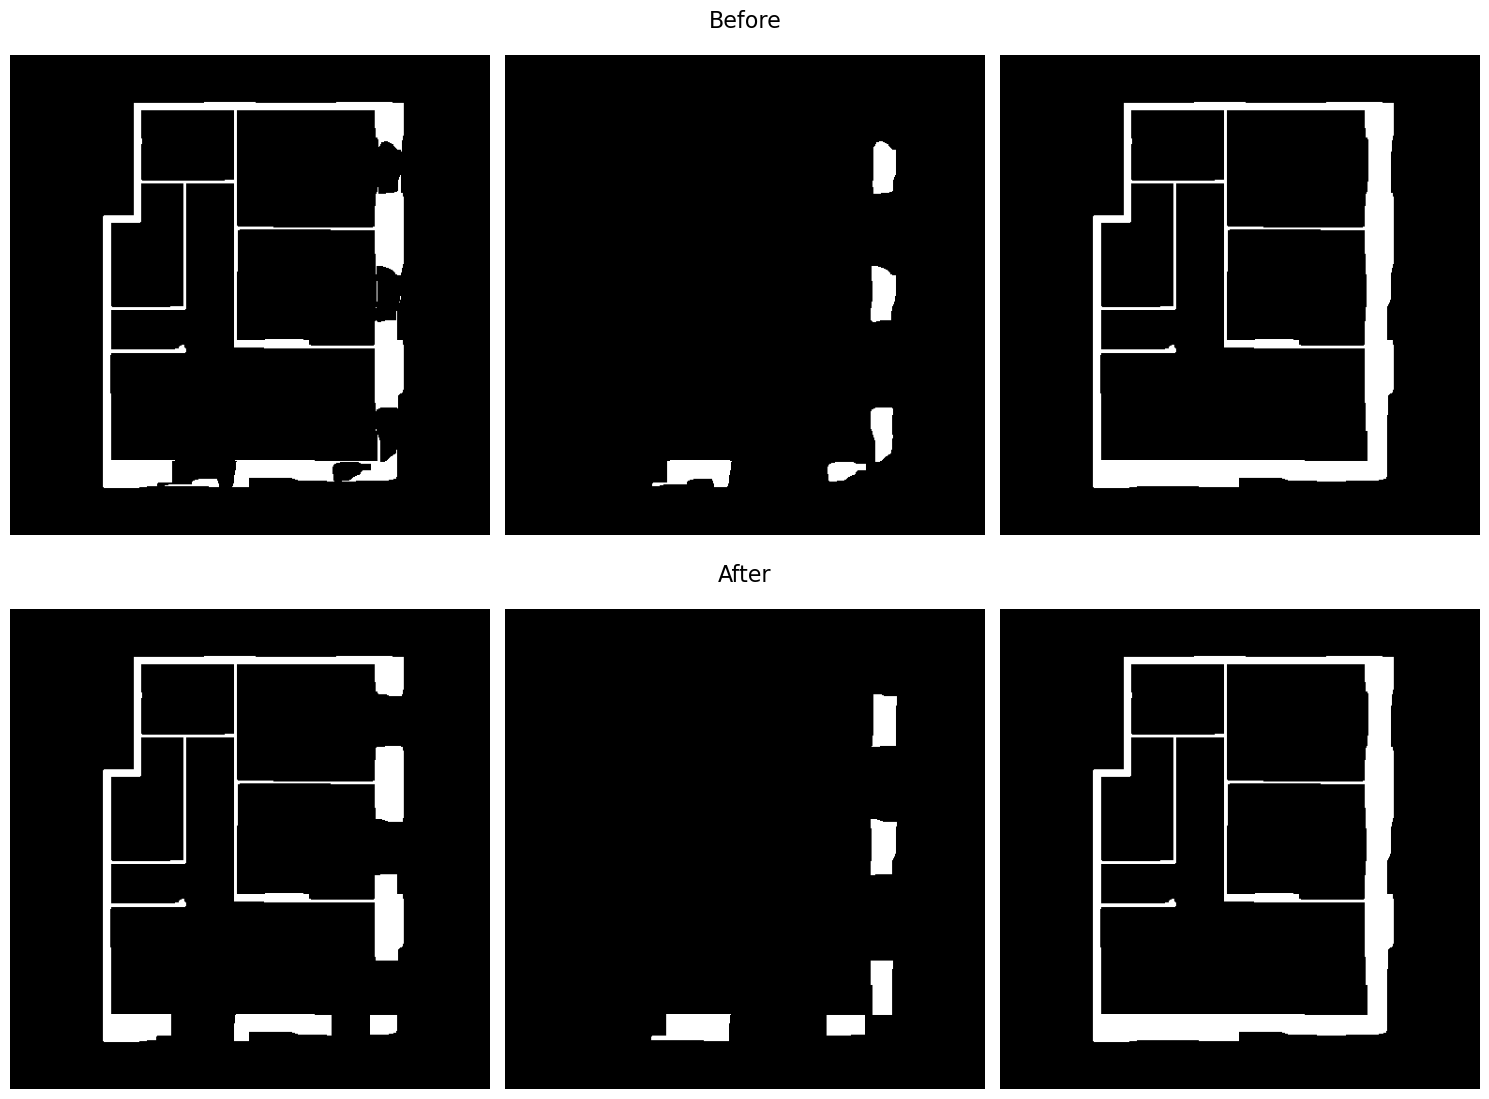

In [46]:
l = list(getic(wall,wind,30)) + [wall]
m = [waw, wind, wall]
fig, axes = plt.subplots(2, 3, figsize=(15, 12))

for j in range(3):
    img = m[j]
    axes[0, j].imshow(img,cmap='grey')
    axes[0, j].axis('off')
axes[0, 1].set_title('Before', fontsize=16, pad=20)

for j in range(3):
    img = l[j]
    axes[1, j].imshow(img,cmap='grey')
    axes[1, j].axis('off')
axes[1, 1].set_title('After', fontsize=16, pad=20)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [48]:
yar1, door2 = getic(wall,door,30)
yar3, wind2 = getic(wall,wind,30)
yar2 = np.logical_and(getic(wall,wind,30)[0].astype(np.bool_), getic(wall,door,30)[0].astype(np.bool_)).astype(np.uint8)
yar4 = wall.copy()
zone = crop(zo2)[2]
flor = 1-crop(zo2)[0]

In [51]:
array = np.array([yar1, door2, yar3, wind2, yar2, yar4, zone, flor])

In [55]:
np.save('./Mask/array.npy', array)

In [22]:
def inner(zo):
    zo = zo.copy()
    contours, hierarchy = cv2.findContours(zo[0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    inner_spot_mask = np.zeros_like(zo[0])
    cv2.fillPoly(inner_spot_mask, contours[2:], 1)
    mask = inner_spot_mask.astype(np.bool_)
    zo[0][mask] = 0
    zo[2][mask] = 1
    return zo.astype(np.uint8)

def crop(zo, s=20):
    zo = zo.copy()
    zo[1] = binary_dilation(zo[1], structure=np.ones((s, s))).astype(int)
    zo[1] = 1 - binary_dilation(1 - zo[1], structure=np.ones((s, s))).astype(int)
    zo[2] = binary_dilation(1-zo[2], structure=np.ones((s, s))).astype(int)
    zo[2] = binary_dilation(1-zo[2], structure=np.ones((s, s))).astype(int)
    zo[0][zo[1]+zo[2]==0] = 1
    zo[0][zo[1]+zo[2]==1] = 0
    return zo.astype(np.uint8)

def crop2(zo, s=20):
    zo = zo.copy()
    zo[1] = binary_dilation(zo[1], structure=np.ones((s, s))).astype(int)
    zo[1] = 1 - binary_dilation(1 - zo[1], structure=np.ones((s, s))).astype(int)
    zo[2] = binary_dilation(zo[2], structure=np.ones((s, s))).astype(int)
    zo[2] = 1-binary_dilation(1-zo[2], structure=np.ones((s, s))).astype(int)
    zo[0][zo[1]+zo[2]==0] = 1
    zo[0][zo[1]+zo[2]==1] = 0
    return zo.astype(np.uint8)

def filt(ic, t=30):
    ic = ic.copy()
    contours, _ = cv2.findContours(ic[2], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if not (w>t or h>t) :
            cv2.fillPoly(ic[2], [c], 0)
    contours, _ = cv2.findContours(ic[1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if not (w>t or h>t):
            cv2.fillPoly(ic[1], [c], 0)
    return ic.astype(np.uint8)

def getic(wall, icons, s=20):
    f_w = binary_dilation(icons, structure=np.ones((s, s))).astype(int)
    w_w = wall - f_w
    w_w[w_w==-1] = 0
    mask1 = np.logical_and(f_w.astype(np.bool_), wall.astype(np.bool_))
    f_wa = binary_dilation(w_w, structure=np.ones((s, s))).astype(int)
    mask2 = np.logical_or(wall.astype(np.bool_), mask1)
    f_wa[mask2==False] = 0
    win = mask1.astype(int) - f_wa
    win[win==-1]=0
    return f_wa.astype(np.uint8), win.astype(np.uint8)

def block(cons, bot, top):
    faces = []
    for con in cons:
        cp = list(con)
        cp += [cp[0]]
        for i in range(len(cp)-1):
            p1 = cp[i][0]
            p2 = cp[i+1][0]
            q1 = (p1[0], p1[1], bot)
            q2 = (p2[0], p2[1], bot)
            q3 = (p2[0], p2[1], top)
            q4 = (p1[0], p1[1], top)
            faces += [[q1, q2, q3, q4]]
    return faces

def bound(cons, h):
    faces = []
    for con in cons:
        sur = []
        for p in con:
            sur += [(p[0][0], p[0][1], h)]
        faces += [sur]
    return faces

def POST (zo, ic):
    zo2 = inner(zo.astype(np.uint8))
    f = filt(crop2(ic))
    wind = f[1]
    door = f[2]
    c = crop(zo2,s=30)
    wall = c[1]
    zone = c[2]
    back1 = np.ones_like(zone) - zone - wall
    back2 = np.ones_like(door) - door - wind

    return np.stack([back1, wall, zone, back2, wind, door])

In [23]:
POST(zo, ic)

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   